In [1]:
import pandas as pd
bike_data_raw = pd.read_csv('daily-bike-share.csv')
bike_data_raw

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,12/27/2012,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247
727,728,12/28/2012,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644
728,729,12/29/2012,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159
729,730,12/30/2012,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364


In [2]:
bike_data_raw['dteday'] = pd.to_datetime(bike_data_raw['dteday'])
bike_data = bike_data_raw.copy()
bike_data.drop(['instant', 'dteday', 'yr'], axis=1, inplace=True)

In [3]:
numeric_features = ['temp', 'atemp', 'hum', 'windspeed']
categorical_features = ['season','mnth','holiday','weekday','workingday','weathersit']
target = 'rentals'

In [4]:
bike_data['difference_temp'] = (bike_data['atemp'] - bike_data['temp'])/bike_data['temp']
bike_data.drop(['atemp'], axis=1, inplace=True)
numeric_features = ['temp', 'difference_temp', 'hum', 'windspeed']

In [6]:
X = bike_data[['temp']].copy()
y = bike_data[target].copy()

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f'X.shape: {X.shape}, y.shape {y.shape}')
print()
print(f'X_train.shape: {X_train.shape}, y_train.shape {y_train.shape}')
print(f'X_test.shape: {X_test.shape}, y_test.shape {y_test.shape}')

X.shape: (731, 1), y.shape (731,)

X_train.shape: (584, 1), y_train.shape (584,)
X_test.shape: (147, 1), y_test.shape (147,)


In [8]:
from sklearn.linear_model import LinearRegression
lr_model_orig = LinearRegression() # inicjalizacja modelu
lr_model_orig.fit(X_train, y_train) # trenowanie modelu

LinearRegression()

In [9]:
y_predict_train = lr_model_orig.predict(X_train)
y_predict_test = lr_model_orig.predict(X_test)

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import ElasticNet

In [14]:
import numpy as np
cv = KFold(n_splits=5, shuffle=False)

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

# Podział na zmienne objaśniające i zmienną objaśnianą
X = bike_data[numeric_features+categorical_features].copy()
y = bike_data[target].copy()

# Podział na zbiór treningowy i testowy (taki sam podział co poprzednio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
numeric_transformer = Pipeline(steps=[
    ('logtransformer', PowerTransformer()),
    ('standardscaler', StandardScaler()),
    ('polynomialfeatures', PolynomialFeatures())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Tworzenie końcowego Pipeline, który będziemy trenować
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', ElasticNet())])

params = {'preprocessor__num__polynomialfeatures__degree': [1, 2, 3, 4, 5],
          'regressor__alpha': [1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0],
          'regressor__l1_ratio': np.arange(0, 1.1, 0.1)}

final_polynomial_regression_gridsearch = GridSearchCV(final_pipeline,
                                                      params,
                                                      scoring='neg_mean_squared_error',
                                                      cv=cv)

final_polynomial_regression_gridsearch.fit(X_train, y_train)
print("\nNajlepsze hiperparametry:", final_polynomial_regression_gridsearch.best_params_, "\n")

final_polynomial_regression_model = final_polynomial_regression_gridsearch.best_estimator_
predictions = final_polynomial_regression_model.predict(X_test)
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, predictions))}')

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.188e+07, tolerance: 2.207e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.899e+07, tolerance: 2.268e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fi


Najlepsze hiperparametry: {'preprocessor__num__polynomialfeatures__degree': 1, 'regressor__alpha': 0.1, 'regressor__l1_ratio': np.float64(0.4)} 

RMSE: 483.93794140501114


In [18]:
print(f'Test R^2: {r2_score(y_test, predictions)}')
print(f'Test MAE: {mean_absolute_error(y_test, predictions)}')
print(f'Test MAPE: {mean_absolute_percentage_error(y_test, predictions)}')
print(f'Test MSE: {mean_squared_error(y_test, predictions)}')

Test R^2: 0.5246818862090765
Test MAE: 348.5851935515566
Test MAPE: 0.8593319730028237
Test MSE: 234195.93113132


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

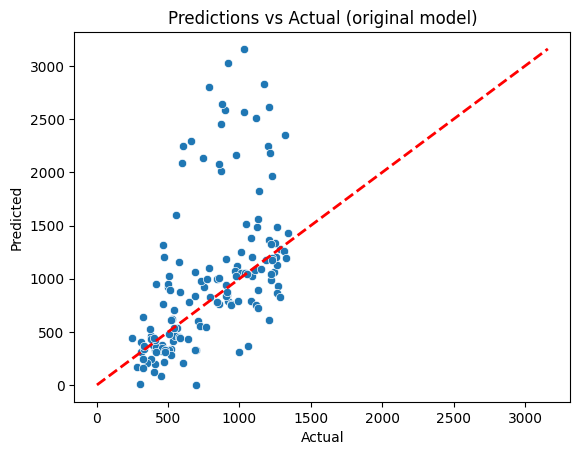

In [24]:
sns.scatterplot(x=y_predict_test, y=y_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predictions vs Actual (original model)')
plt.show()

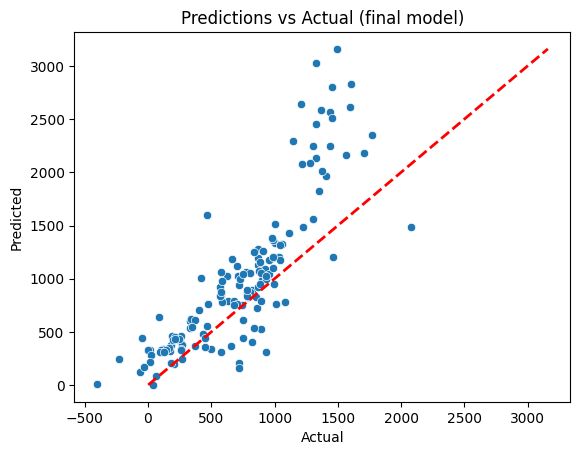

In [25]:
sns.scatterplot(x=predictions, y=y_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predictions vs Actual (final model)')
plt.show()

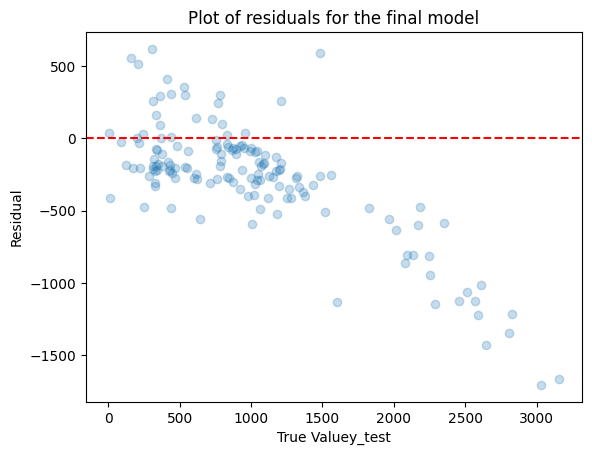

In [26]:
errors = predictions - y_test
plt.scatter(x = y_test, y = errors, alpha=0.25)
plt.axhline(0, color="r", linestyle="--")
plt.xlabel('True Valuey_test')
plt.ylabel('Residual')
plt.title(f'Plot of residuals for the final model')
plt.show()

Porównanie oryginalnego modelu do finalnego:

R^2: 0.306 vs 0.525 - wartość dla modelu finalnego jest znacznie bliższa 1, co znaczy, że uzyskaliśmy lepsze dopasowanie modelu. Niestety, wciąż daleko jest nam do idealnej wartości 1.

MAE: 391.03 vs 348.59 - średni błąd absolutny jest dla finalnego modelu mniejszy. W finalnym modelu średnio mylimy się o ok. 349 rowerów.

MAPE: 2.99 vs 0.86 - tutaj mamy dużą poprawę, początkowo średnio myliliśmy się o 300%, a teraz o 86%.

MSE: 397066.94 vs 234195.93 - tutaj również duża poprawa.

RMSE: 630.13 vs 483.94 - również.


Z porównania tych metryk oraz wizualizacji predykcji vs rzeczywistych obserwacji dla pierwotnego i finalnego modelu wynika, że nasze predykcje znacznie się poprawiły. Dalej nie jest jednak idealnie. Nasz model dalej ma jednak tendencję do niedoszacowywania, zwłaszcza dla wysokich wartości. Wykres reszt dalej nie w pełni przypomina 'chmurę' (wręcz dalej przypomina linię z negatywną pochyłą), czyli, że dalej pewna zależność dalej nie została wyjaśniona. Jest jednak znacznie lepiej, niż pierwotnie.